## Import Libraries

In [3]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn import metrics

%matplotlib inline

## Load the Data

In [4]:
df = pd.read_csv('final_data.csv')
df.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [5]:
df.shape

(10754, 22)

## Preprocess the Data

Irrelevant columns

In [6]:
#drop irrelevant columns and Remove categorical columns to include only numerical data for K-means clustering
df.drop(columns= 'player', inplace = True)
df.drop(columns= 'position_encoded', inplace = True)
df.drop(columns= 'winger', inplace = True)
df.drop(columns=['name', 'team', 'position'], inplace=True)

Outlier

In [7]:
#I won't handle outliers manually; I will try to use RobustScaler to manage them

#### 2. Feature engineering

In [8]:
# Convert scaled values back to their original scale by multiplying with 'appearance'
multiply = ['goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets']

for column in multiply:
    name = column.replace(' ', '_') + '_total'  # Generate new column name by replacing spaces with underscores and appending '_total'
    df[name] = (df[column] * df['appearance']).astype(int)  # Multiply the column values by 'appearance' and convert to integers


In [9]:
# Drop the original columns with scaled values 
df.drop(columns=['goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets'], inplace=True)

In [10]:
df.shape

(10754, 16)

In [11]:
df.columns

Index(['height', 'age', 'appearance', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'goals_total', 'assists_total', 'yellow_cards_total',
       'second_yellow_cards_total', 'red_cards_total', 'goals_conceded_total',
       'clean_sheets_total'],
      dtype='object')

#### 3. Feature selection

1. Select features based on correlation

In [12]:
# the correlation values of 'current_value' with all other numerical columns, sorted in descending order
correlation = df.corr(numeric_only=True)
print(correlation['current_value'].sort_values(ascending=False))


current_value                1.000000
highest_value                0.834553
minutes played               0.420542
appearance                   0.419656
assists_total                0.405865
goals_total                  0.357890
award                        0.300454
yellow_cards_total           0.261134
games_injured                0.135654
days_injured                 0.107686
second_yellow_cards_total    0.049543
red_cards_total              0.045557
height                       0.040535
clean_sheets_total           0.023668
goals_conceded_total        -0.000181
age                         -0.050156
Name: current_value, dtype: float64


In [13]:
# Define the correlation threshold
threshold = 0.4  

# Filter and select features with a correlation greater than the threshold
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index

# Display the selected feature names
selected_features


Index(['appearance', 'minutes played', 'current_value', 'highest_value',
       'assists_total'],
      dtype='object')

**#Now, let's see the selected features and filter out multicollinearity.**

In [14]:
#First, let's see the correlation between the columns.
df_num = df.select_dtypes(include=['number']) # Select numerical columns from the DataFrame

# Calculate the correlation matrix for the numerical columns
correlation = df_num.corr()

In [15]:
import plotly.express as px

# Create a heatmap of the correlation matrix with Plotly
fig = px.imshow(correlation, text_auto=True, color_continuous_scale='Viridis')

# Update the layout of the heatmap
fig.update_layout(
    width=800,  # Set the width of the heatmap
    height=600,  # Set the height of the heatmap
    xaxis_title='Features',  # Label for the x-axis
    yaxis_title='Features',  # Label for the y-axis
    xaxis=dict(tickvals=list(correlation.columns), ticktext=list(correlation.columns)),  # Set x-axis tick labels
    yaxis=dict(tickvals=list(correlation.columns), ticktext=list(correlation.columns))   # Set y-axis tick labels
)

# Display the heatmap
fig.show()


In [16]:
'''
'appearance' and 'minutes played' have high correlation; I will keep 'appearance.
'current_value' and 'highest_value' have high correlation; I will keep 'highest_value'.
'''

"\n'appearance' and 'minutes played' have high correlation; I will keep 'appearance.\n'current_value' and 'highest_value' have high correlation; I will keep 'highest_value'.\n"

In [17]:
# Define a list of selected features based on previous analysis
selected_features = ['appearance', 'highest_value', 'assists_total']

# Create a new DataFrame  containing only the selected features based on correlation
df_with_correlation = df[selected_features]

# Display the first few rows of the new DataFrame
df_with_correlation.head()


,appearance,highest_value,assists_total
0,104,70000000,0
1,15,22000000,0
2,4,6000000,0
3,82,50000000,4
4,63,80000000,1


2. Select features based on meaning

**Select features that capture a meaningful differences between the data points**

In [18]:
selected_features = ['minutes played', 'current_value', 'age'] #These features represent economic value, participation level, and career stage, providing a well-rounded view of the players’ profiles

# Create a new DataFrame containing the selected features based on meaning
df_with_meaning = df[selected_features]

# Display the first few rows of the new DataFrame
df_with_meaning.head()

,minutes played,current_value,age
0,9390,15000000,32.0
1,1304,1500000,30.0
2,292,600000,37.0
3,6408,50000000,25.0
4,5031,40000000,30.0


3. Select features based on PCA

**Use PCA to reduce the high dimensionality of the data**

In [19]:
# First, we need to scale the data because PCA is sensitive to the scale of the features
scaler = RobustScaler() # sacle the data using RobustScaler
X_scaled = scaler.fit_transform(df)

In [20]:
# Apply Principal Component Analysis (PCA) 
pca = PCA(n_components = 3)  # Initialize PCA to reduce to 3 dimensions
pca.fit(X_scaled)
PCA_scaled = pca.transform(X_scaled)  # Fit PCA and transform the scaled features


In [21]:
#generate a DataFrame where rows are principal components and columns are original features, showing the contribution of each feature to each principal component

# Extract the principal component loadings from  PCA 
components = pca.components_

# Get the feature names from the DataFrame 
feature_names = df.columns  

# Create a DataFrame to display the principal component loadings
components_df = pd.DataFrame(components, columns=feature_names, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Print the principal components (loadings) DataFrame
print("Principal Components (loadings):")
print(components_df)


Principal Components (loadings):
       height       age  appearance  minutes played  days_injured  \
PC1  0.013616  0.005106    0.004137        0.009190     -0.000138   
PC2  0.005937  0.010607    0.061222        0.063817      0.044837   
PC3  0.004128  0.105148    0.000173        0.002570      0.102982   

     games_injured     award  current_value  highest_value  goals_total  \
PC1      -0.000547  0.005009       0.000203       0.002111    -0.014042   
PC2       0.054408  0.207677       0.716034       0.626869     0.146701   
PC3       0.115526  0.430859      -0.254722       0.105875    -0.033593   

     assists_total  yellow_cards_total  second_yellow_cards_total  \
PC1      -0.011548           -0.006717                  -0.001797   
PC2       0.116555            0.048382                   0.005476   
PC3      -0.026563           -0.009139                  -0.001049   

     red_cards_total  goals_conceded_total  clean_sheets_total  
PC1        -0.000828              0.977808     

1. **PC1**: Primarily reflects **defensive performance**, with `goals_conceded_total` being the most significant contributor (0.977808).

2. **PC2**: Represents **player recognition and market value**, highlighted by `current_value` (0.716034) and `award` (0.207677).

3. **PC3**: Indicates a mix of **defensive metrics and player experience**, with `clean_sheets_total` (0.818379) being a key factor.

In [22]:
# Convert PCA results to DataFrame
df_with_PCA = pd.DataFrame(PCA_scaled, columns=['PC1', 'PC2', 'PC3'])

#### 4. Prepare train and test data

In [23]:
# Sacle df_with_correlation and df_with_meaning
scaler = RobustScaler() # sacle the data using RobustScaler
correlation_scaled = scaler.fit_transform(df_with_correlation) 
meaning_scaled = scaler.fit_transform(df_with_meaning) 

### Choose the the number of clusters (k)

**K for Correlation Data**

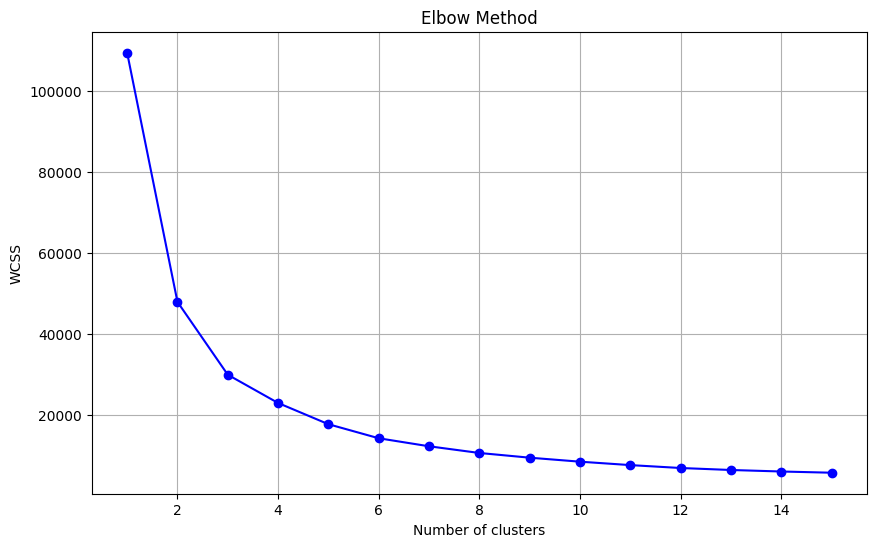

In [24]:
# Determine the optimal number of clusters for K-means clustering using the Elbow method
wcss = []

# Loop through a range of cluster numbers from 1 to 15
for i in range(1, 16):  # Test 1 to 15 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=400, n_init=30, random_state=42)
    kmeans.fit(correlation_scaled) # Fit KMeans to the correlation data
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(wcss) + 1), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


**K for Meaning Data**

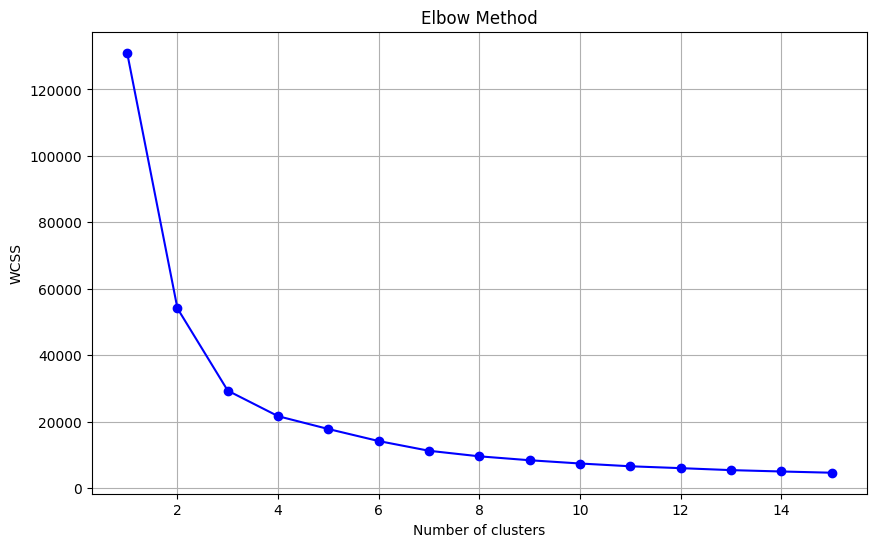

In [25]:
# Determine the optimal number of clusters for K-means clustering using the Elbow method
wcss = []

# Loop through a range of cluster numbers from 1 to 15
for i in range(1, 16):  # Test 1 to 15 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=400, n_init=30, random_state=42)
    kmeans.fit(meaning_scaled) # Fit KMeans to the meaning data
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(wcss) + 1), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

**K for PCA Data**

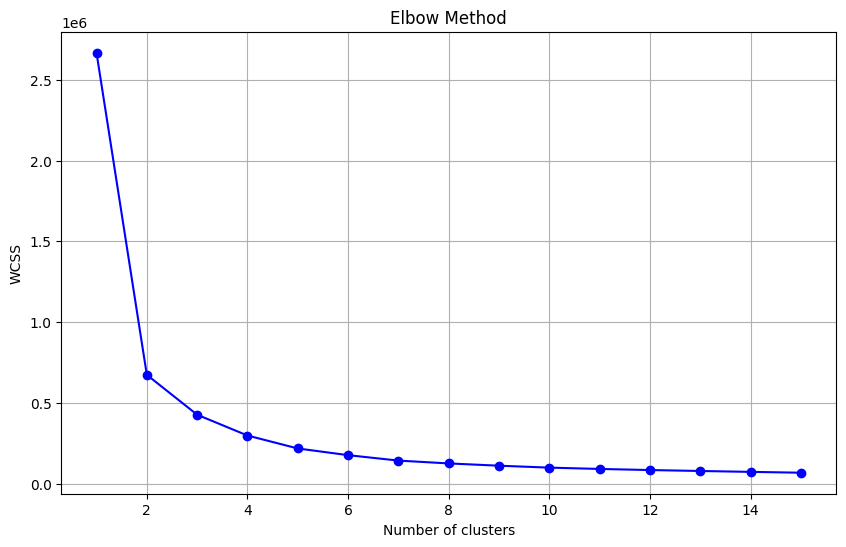

In [26]:
# Determine the optimal number of clusters for K-means clustering using the Elbow method
wcss = []

# Loop through a range of cluster numbers from 1 to 15
for i in range(1, 16):  # Test 1 to 15 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++',  max_iter=400, n_init=30, random_state=42)
    kmeans.fit(PCA_scaled) # Fit KMeans to the PCA-transformed data
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(wcss) + 1), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

After trying k = 3 , k = 4 and k = 5




I will use 4 clusters for all the models k = 4

## Buliding the Model

In [27]:
# Set the optimal number of clusters based on previous analysis (e.g., Elbow method)
optimal_clusters = 4

# Initialize and fit the KMeans model with the optimal number of clusters
model_correlation = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
model_meaning = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
model_PCA = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

## Train and Test the Model

In [28]:
# Fit the correlation model
fit_correlation =  model_correlation.fit(correlation_scaled)
kmean_correlation = model_correlation.fit_predict(correlation_scaled)

# Fit the meaning model
fit_meaning = model_meaning.fit(meaning_scaled)
kmean_meaning = model_meaning.fit_predict(meaning_scaled)

# Fit the PCA model
fit_PCA = model_PCA.fit(PCA_scaled)
kmean_PCA = model_PCA.fit_predict(PCA_scaled)

In [48]:
import joblib
joblib.dump(model_meaning, 'kmean_model.joblib')
joblib.dump(scaler, 'kmean_model/scaler.joblib')


FileNotFoundError: [Errno 2] No such file or directory: 'kmean_model/scaler.joblib'

In [49]:
joblib.dump(scaler, 'kmean_model/scaler.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'kmean_model/scaler.joblib'

In [50]:
# Load the KMeans model
model_meaning = joblib.load('kmean_model.joblib')

# Load the scaler
scaler = joblib.load('kmean_model/scaler.joblib')


FileNotFoundError: [Errno 2] No such file or directory: 'kmean_model/scaler.joblib'

## Evaluating the Model 

**Add Cluster column**

In [29]:
# Add the cluster assignments as a new column to the DataFrame
df_with_correlation['Cluster'] = kmean_correlation

# Display the first few rows of the updated DataFrame
df_with_correlation.head()

,appearance,highest_value,assists_total,Cluster
0,104,70000000,0,1
1,15,22000000,0,2
2,4,6000000,0,3
3,82,50000000,4,2
4,63,80000000,1,1


In [30]:
# Count the number of data points in each cluster and display the counts
df_with_correlation['Cluster'].value_counts()

Cluster
3    7492
0    2313
2     783
1     166
Name: count, dtype: int64

In [31]:
df_with_meaning['Cluster'] = kmean_meaning
df_with_meaning.head()

,minutes played,current_value,age,Cluster
0,9390,15000000,32.0,2
1,1304,1500000,30.0,0
2,292,600000,37.0,0
3,6408,50000000,25.0,1
4,5031,40000000,30.0,1


In [32]:
df_with_meaning['Cluster'].value_counts()

Cluster
0    9415
2     981
1     285
3      73
Name: count, dtype: int64

In [33]:
df_with_PCA['Cluster'] = kmean_PCA
df_with_PCA.head()

,PC1,PC2,PC3,Cluster
0,126.738612,13.137719,8.257916,1
1,14.616568,1.421250,0.136661,0
2,-1.037900,-0.552550,3.672146,0
3,-3.608304,19.222855,-1.813833,3
4,-3.525395,21.822229,2.705592,3


In [34]:
df_with_PCA['Cluster'].value_counts()

Cluster
0    9574
3     551
2     398
1     231
Name: count, dtype: int64

**Silhouette_score**

In [35]:
from sklearn.metrics import silhouette_score

# Evaluate the quality of clusters
silhouette_correlation = silhouette_score(correlation_scaled, model_correlation.labels_)
silhouette_meaning = silhouette_score(meaning_scaled, model_meaning.labels_)
silhouette_PCA = silhouette_score(PCA_scaled, model_PCA.labels_)

print(f'Silhouette Score for Correlation Model: {silhouette_correlation}')
print(f'Silhouette Score for Meaning Model: {silhouette_meaning}')
print(f'Silhouette Score for PCA Model: {silhouette_PCA}')


Silhouette Score for Correlation Model: 0.5159776606260414
Silhouette Score for Meaning Model: 0.6543917398149691
Silhouette Score for PCA Model: 0.7809177048647131


- **PCA Model**: Best clustering, highest Silhouette Score (0.7809).
- **Meaning Model**: Good clustering, second-best score (0.6578).
- **Correlation Model**: Moderate clustering, lowest score (0.5129).

**Inertia**

In [36]:
# Assuming the KMeans models are already defined and fitted

# Get inertia from the fitted models
inertia_correlation = model_correlation.inertia_
inertia_meaning = model_meaning.inertia_  # Corrected line
inertia_PCA = model_PCA.inertia_

print(f'Correlation Model Inertia: {inertia_correlation}')
print(f'Meaning Model Inertia: {inertia_meaning}')  # Corrected line
print(f'PCA Model Inertia: {inertia_PCA}')


Correlation Model Inertia: 23046.251730189262
Meaning Model Inertia: 21610.312385961803
PCA Model Inertia: 299084.0440911753


**Meaning Model**: Best compactness with the lowest inertia (21,877.29).

**Correlation Model**: Moderate compactness with middle inertia (23,352.61).

**PCA Model**: Least compact with the highest inertia (299,084.04).

Based on these inertia values, the **Meaning Model** has the most compact clusters.

While the Meaning Model excels in compactness, the PCA Model provides superior cluster separation


In [37]:
from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index for df_with_correlation
db_index_correlation = davies_bouldin_score(df_with_correlation, kmean_correlation)
print(f'Davies-Bouldin Index for Correlation Data: {db_index_correlation}')

# Davies-Bouldin Index for df_with_meaning
db_index_meaning = davies_bouldin_score(df_with_meaning, kmean_meaning)
print(f'Davies-Bouldin Index for Meaning Data: {db_index_meaning}')

# Davies-Bouldin Index for df_with_PCA
db_index_PCA = davies_bouldin_score(df_with_PCA, kmean_PCA)
print(f'Davies-Bouldin Index for PCA Data: {db_index_PCA}')


Davies-Bouldin Index for Correlation Data: 0.7832586565123805
Davies-Bouldin Index for Meaning Data: 0.4861222478732805
Davies-Bouldin Index for PCA Data: 0.5808331376710558


- **Best Clustering Quality**: Meaning Data, with the lowest Davies-Bouldin Index (0.4861).
- **Next Best**: PCA Data, with a Davies-Bouldin Index of 0.5808.
- **Least Effective**: Correlation Data, with the highest Davies-Bouldin Index (0.8865).

#### In the end **Meaning model** offers the best clustering quality, but for a balance between quality and dimensionality reduction, the **PCA model** is best for me.

**Visualize the results of KMeans**

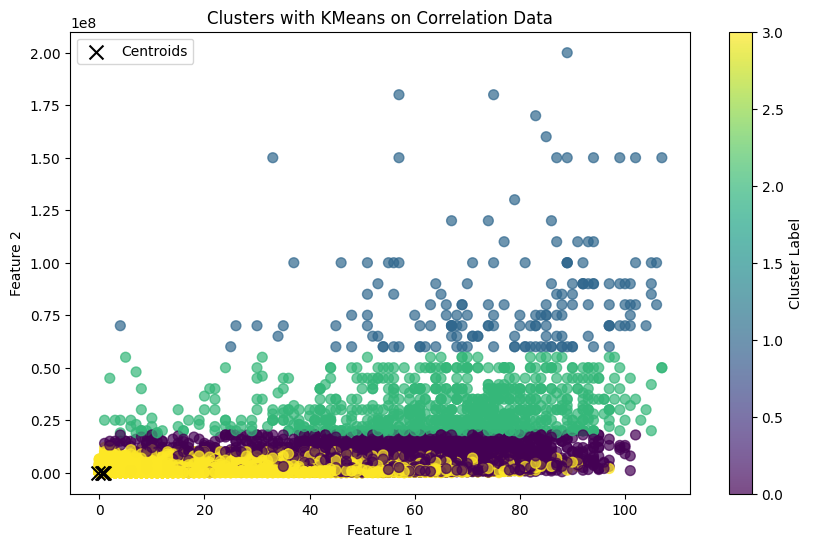

In [38]:
# Extract the first two columns for plotting
X1 = df_with_correlation.iloc[:, 0].values
X2 = df_with_correlation.iloc[:, 1].values

# Plot the data points, color-coded by cluster assignments
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1, X2, c=kmean_correlation, cmap='viridis', marker='o', s=50, alpha=0.7)

# Plot the cluster centroids
centroids = model_correlation.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

# Add plot title and labels
plt.title('Clusters with KMeans on Correlation Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Add legend and color bar, and show the plot
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.show()


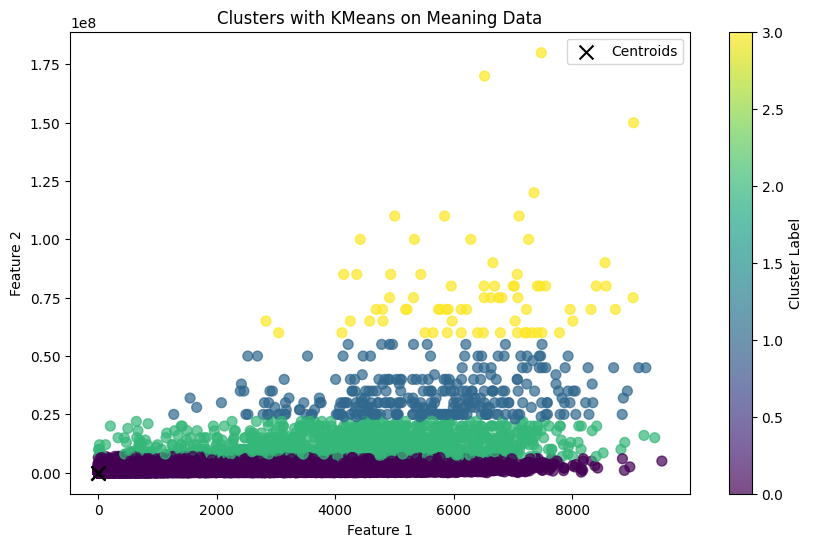

In [39]:
# Extract the first two columns for plotting
X1 = df_with_meaning.iloc[:, 0].values
X2 = df_with_meaning.iloc[:, 1].values

# Plot the data points, color-coded by cluster assignments
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1, X2, c=kmean_meaning, cmap='viridis', marker='o', s=50, alpha=0.7)

# Plot the cluster centroids
centroids = model_meaning.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

# Add plot title and labels
plt.title('Clusters with KMeans on Meaning Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Add legend and color bar, and show the plot
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.show()


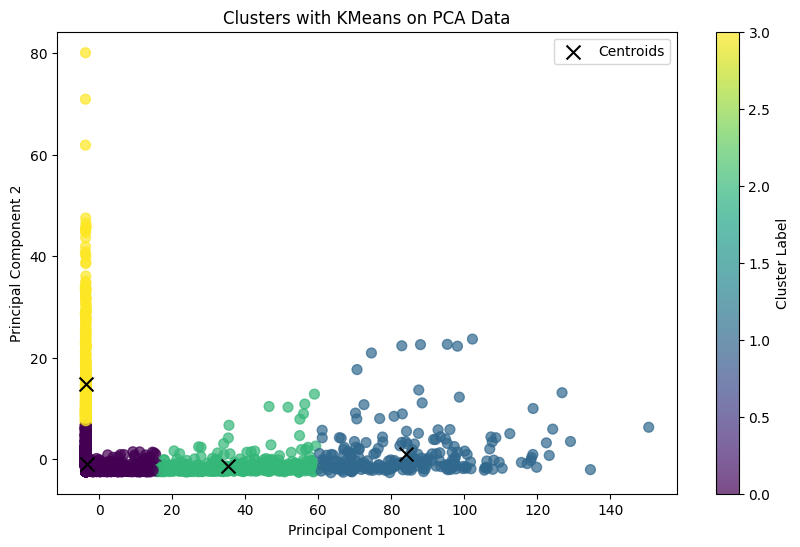

In [40]:
# Extract the first two principal components for plotting
X1 = df_with_PCA.iloc[:, 0].values
X2 = df_with_PCA.iloc[:, 1].values

# Plot the data points, color-coded by cluster assignments
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1, X2, c=kmean_PCA, cmap='viridis', marker='o', s=50, alpha=0.7)

# Plot the cluster centroids
centroids = model_PCA.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='Centroids', marker='x')

# Add plot title and labels
plt.title('Clusters with KMeans on PCA Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend and color bar, and show the plot
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.show()
